In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 589.9 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 301 entries, id to 299
dtypes: float64(300), int64(1)
memory usage: 45.4 MB


# 箱ひげ図などなど

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

相関が1に近ければ正の相関、−１に近ければ負の相関。
要は正の相関があればAが高ければBも高いとなる。

In [6]:
train.isnull().any().any() # is there any NULL cell ?

False

1.0    160
0.0     90
Name: target, dtype: int64

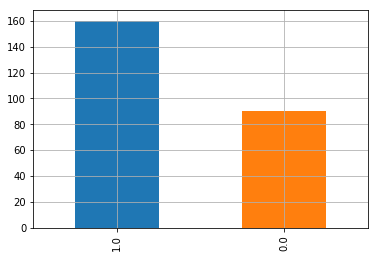

In [7]:
train["target"].value_counts().plot("bar")
plt.grid(True)
train["target"].value_counts()

In [8]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


## データセットの一部を表示して分布を見てみる

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


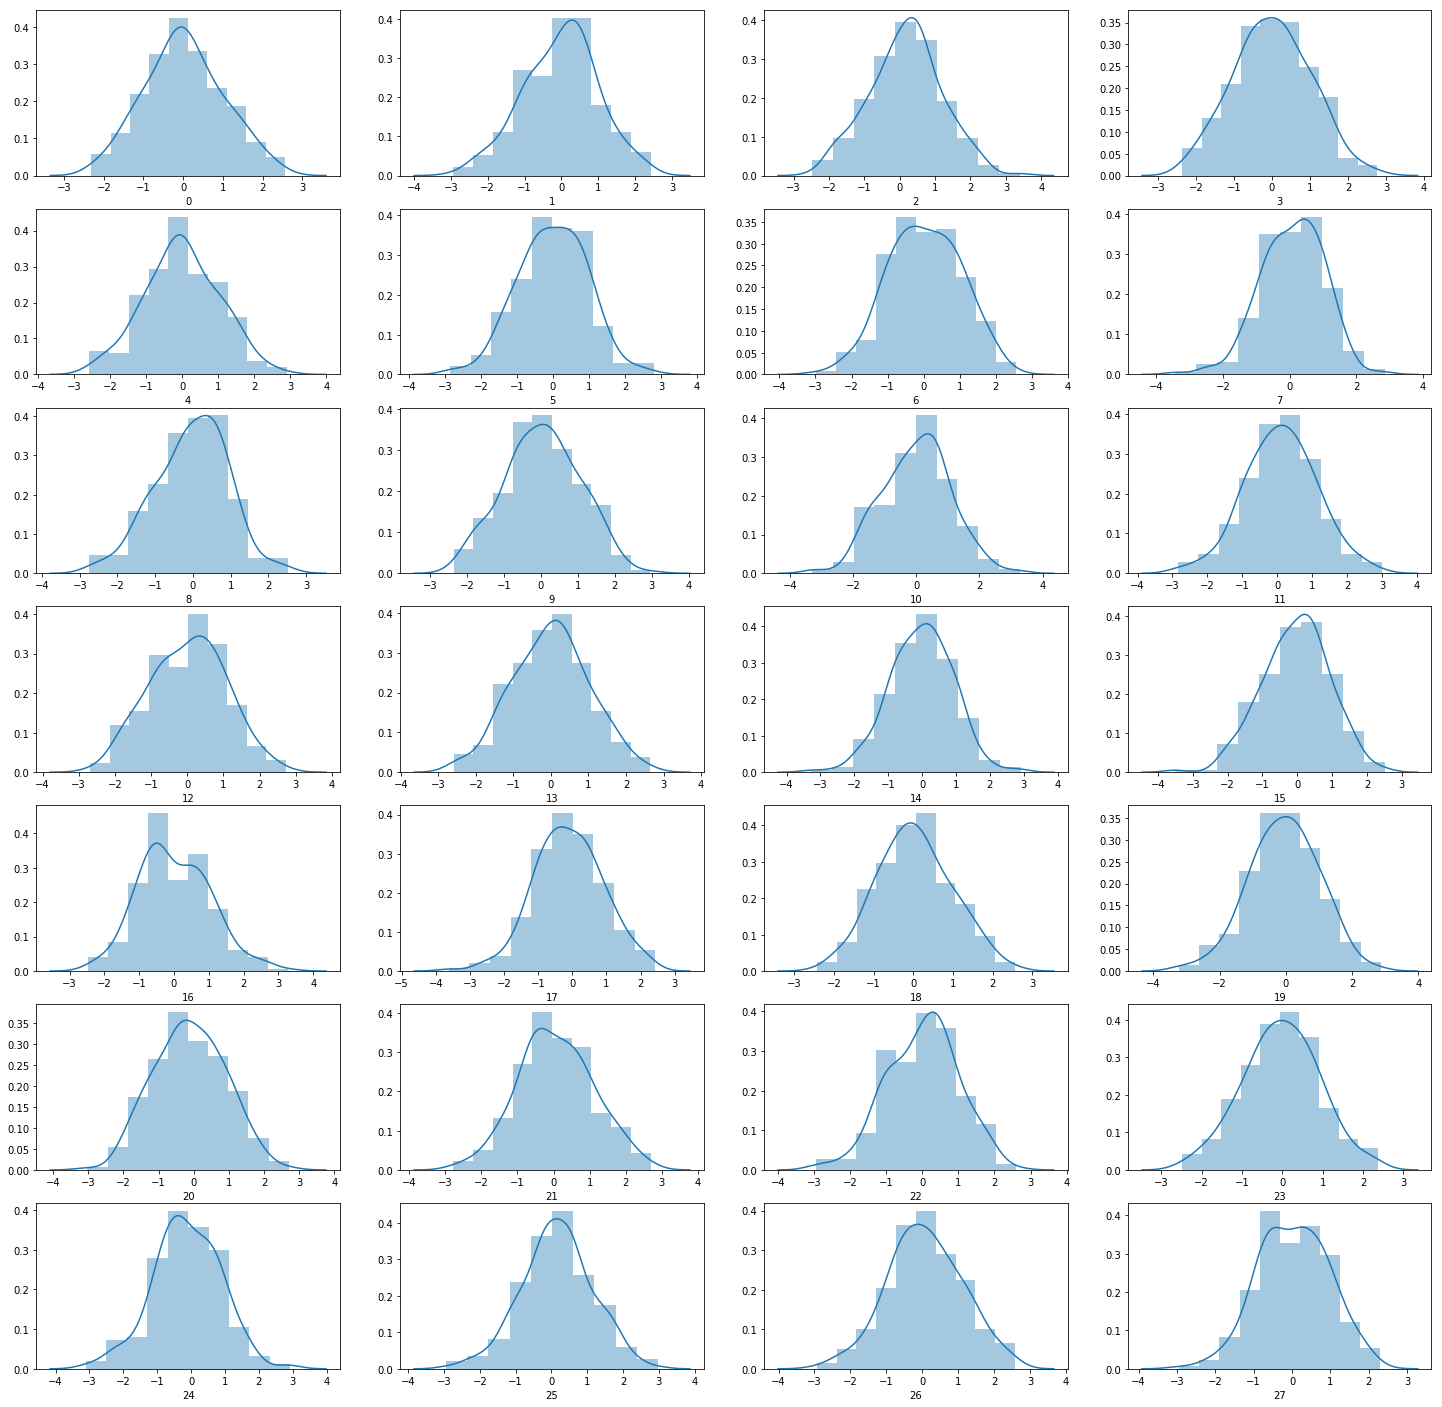

In [9]:
plt.figure(figsize=(25, 25))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i+1)
    sns.distplot(train[col], hist=True, kde=True, rug=False, bins=10)

## 箱ひげ図

一部を表示

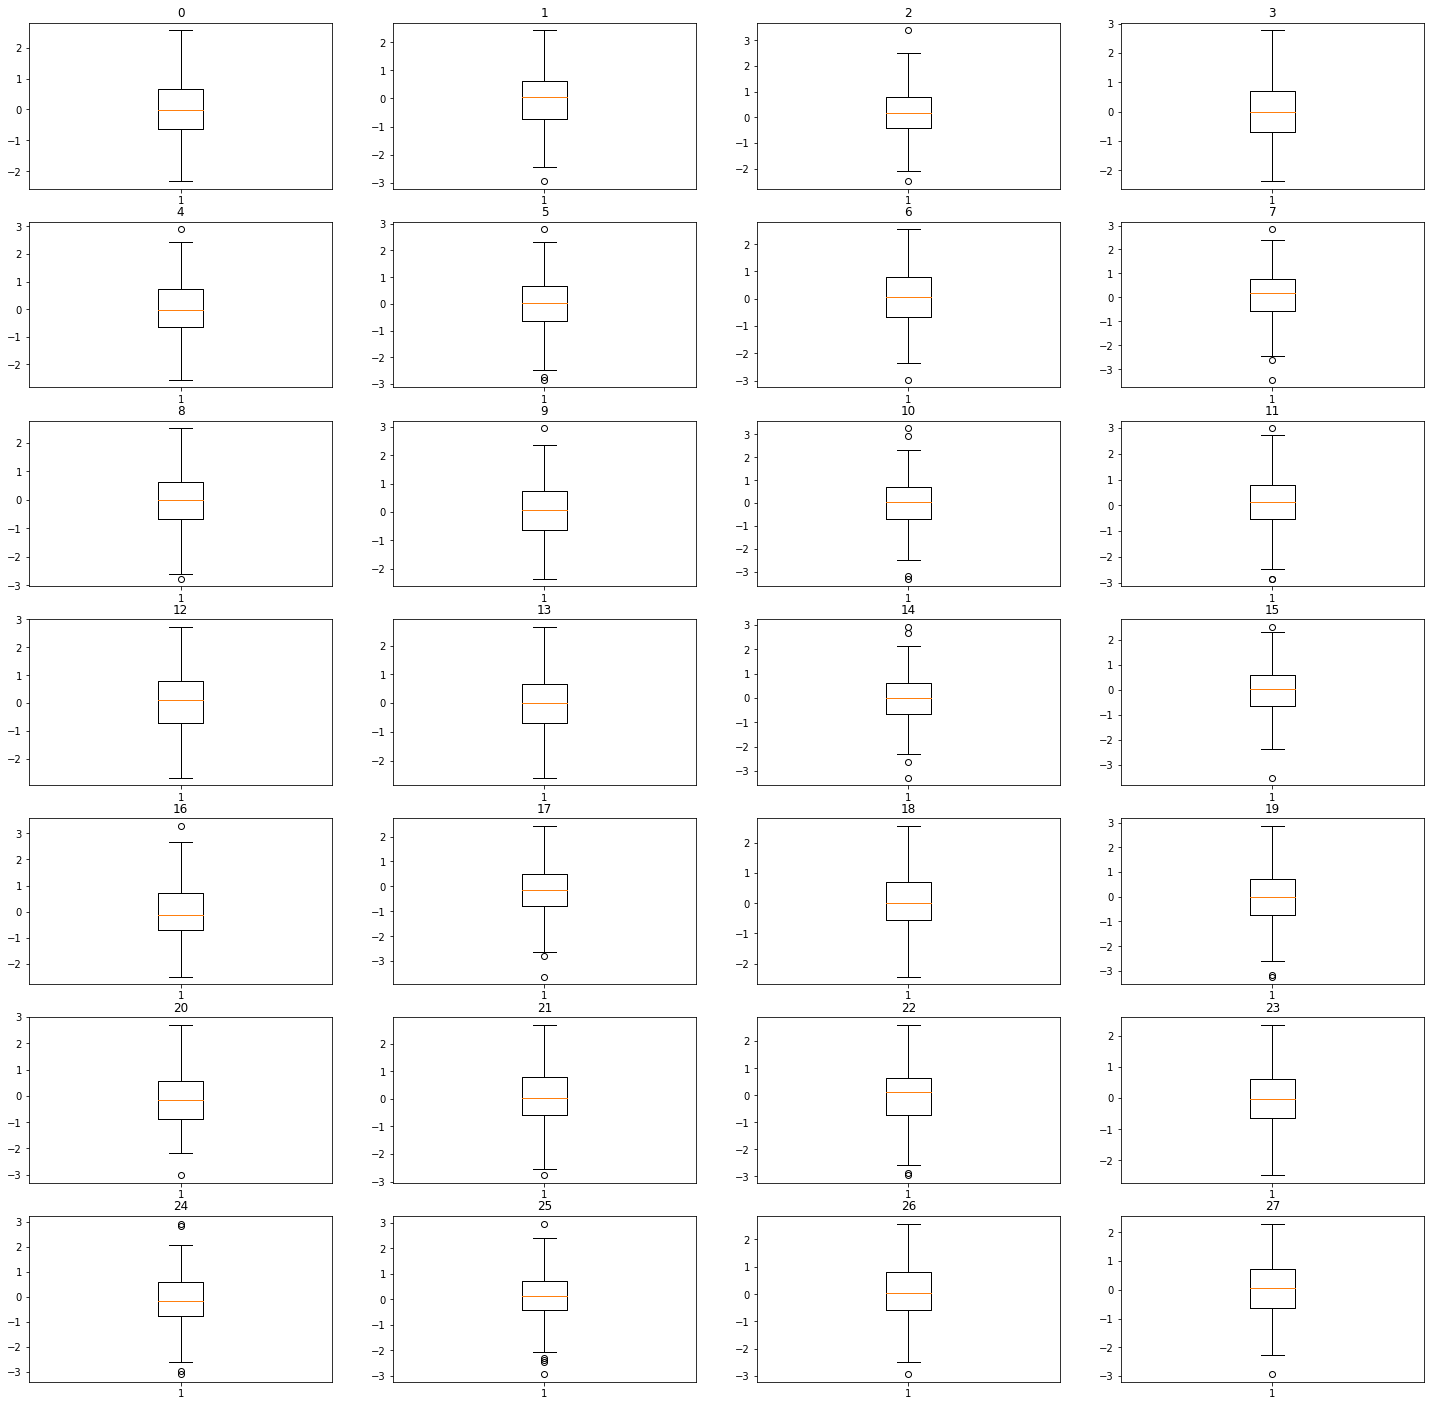

In [10]:
plt.figure(figsize=(25, 25))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i+1)
    plt.boxplot(train[col])
    plt.title(col)

# 特徴間の相関の確認

In [11]:
corr = train.corr().abs().unstack().sort_values().reset_index()
corr = corr[corr["level_0"] != corr["level_1"]]
corr.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


これから特徴間の相関は最大でも0.25程度、targetとの最大の相関も最大で0.37。

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split

x_train_ori = train.drop(["id", "target"], axis=1)
y_train_ori = train["target"]
x_test = test.drop(["id"], axis=1).values
kfolds = StratifiedKFold(n_splits=50, shuffle=True, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train_ori.values, y_train_ori.values)

In [13]:
noisy_x_train = x_train_ori + np.random.uniform(0, 0.01, x_train_ori.shape)

# Simple RandomForest Classifier

[参考になったページ](https://dev.classmethod.jp/machine-learning/yoshim-featuretools-boruta-optuna/)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import boruta

c = 0
model = RandomForestClassifier()
for train_idx, test_idx in kfolds.split(x_train, y_train):
    c += 1
    model.fit(x_train[train_idx], y_train[train_idx])
    print(c, "Val Accuracy: {:.3f}".format(accuracy_score(y_train[test_idx], model.predict(x_train[test_idx]))))


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1 Val Accuracy: 0.400
2 Val Accuracy: 0.400
3 Val Accuracy: 0.800
4 Val Accuracy: 0.400
5 Val Accuracy: 0.600
6 Val Accuracy: 0.400
7 Val Accuracy: 0.600
8 Val Accuracy: 0.400
9 Val Accuracy: 0.800
10 Val Accuracy: 0.800
11 Val Accuracy: 0.600
12 Val Accuracy: 0.600
13 Val Accuracy: 0.600
14 Val Accuracy: 0.800
15 Val Accuracy: 0.400
16 Val Accuracy: 0.800
17 Val Accuracy: 0.600
18 Val Accuracy: 0.500
19 Val Accuracy: 1.000
20 Val Accuracy: 0.750
21 Val Accuracy: 0.667
22 Val Accuracy: 0.333
23 Val Accuracy: 0.667
24 Val Accuracy: 0.333
25 Val Accuracy: 0.667
26 Val Accuracy: 0.667
27 Val Accuracy: 0.667
28 Val Accuracy: 1.000
29 Val Accuracy: 0.667
30 Val Accuracy: 0.333
31 Val Accuracy: 0.333
32 Val Accuracy: 0.000
33 Val Accuracy: 1.000
34 Val Accuracy: 0.333
35 Val Accuracy: 1.000
36 Val Accuracy: 1.000
37 Val Accuracy: 0.667
38 Val Accuracy: 0.333
39 Val Accuracy: 0.333
40 Val Accuracy: 0.667
41 Val Accuracy: 1.000
42 Val Accuracy: 0.667
43 Val Accuracy: 0.667
44 Val Accuracy: 1.0

In [15]:
feat_selector = boruta.BorutaPy(model, n_estimators="auto", verbose=2, alpha=0.05, max_iter=50, random_state=0)
feat_selector.fit(x_train, y_train)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	300
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	0
Tentative: 	8
Rejected: 	292
Iteration: 	9 / 50
Confirmed: 	2
Tentative: 	6
Rejected: 	292
Iteration: 	10 / 50
Confirmed: 	2
Tentative: 	6
Rejected: 	292
Iteration: 	11 / 50
Confirmed: 	2
Tentative: 	6
Rejected: 	292
Iteration: 	12 / 50
Confirmed: 	3
Tentative: 	5
Rejected: 	292
Iteration: 	13 / 50
Confirmed: 	3
Tentative: 	5
Rejected: 	292
Iteration: 	14 / 50
Confirmed: 	3
Tentative: 	5
Rejected: 	292
Iteration: 	15 / 50
Confirmed: 	3
Tentative: 	5
Rejected: 	292
Iteration: 	16 / 50
Confirmed: 	3
Tentative: 	5
Rejected: 	292
I

BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f66a892ae10>,
            verbose=0, warm_start=False),
     max_iter=50, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f66a892ae10>,
     two_step=True, verbose=2)

In [16]:
# 選ばれた特徴量のみの配列を作成
selected_x_train = feat_selector.transform(x_train)
selected_x_val = feat_selector.transform(x_val)

In [17]:
import optuna


def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 5)
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "auto", "log2"])
    
    rfc = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)
    rfc.fit(selected_x_train, y_train) 
    return -1 * rfc.score(selected_x_val, y_val)


study = optuna.create_study()
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2019-05-14 07:34:11,945] Finished trial#3 resulted in value: -0.746031746031746. Current best value is -0.746031746031746 with parameters: {'max_depth': 3, 'n_estimators': 73, 'max_features': 'auto'}.
[I 2019-05-14 07:34:12,130] Finished trial#0 resulted in value: -0.7142857142857143. Current best value is -0.746031746031746 with parameters: {'max_depth': 3, 'n_estimators': 73, 'max_features': 'auto'}.
[I 2019-05-14 07:34:12,307] Finished trial#1 resulted in value: -0.7301587301587301. Current best value is -0.746031746031746 with parameters: {'max_depth': 3, 'n_estimators': 73, 'max_features': 'auto'}.
[I 2019-05-14 07:34:12,662] Finished trial#2 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'max_depth': 4, 'n_estimators': 86, 'max_features': 'auto'}.
[I 2019-05-14 07:34:13,071] Finished trial#6 resulted in value: -0.7142857142857143. Current best value is -0.7936507936507936 with parameters: {'max_depth': 4, 'n_estimators': 86,

In [18]:
print(study.best_params)
print("-"*50)
print(study.best_value)
print("-"*50)
print(study.best_trial)

print("-"*50)
for i in study.trials:
    print("param: {}, eval_value: {}".format(i[5], i[2]))

{'max_depth': 4, 'n_estimators': 86, 'max_features': 'auto'}
--------------------------------------------------
-0.7936507936507936
--------------------------------------------------
FrozenTrial(number=2, state=<TrialState.COMPLETE: 1>, value=-0.7936507936507936, datetime_start=datetime.datetime(2019, 5, 14, 7, 34, 11, 316677), datetime_complete=datetime.datetime(2019, 5, 14, 7, 34, 12, 661095), params={'max_depth': 4, 'n_estimators': 86, 'max_features': 'auto'}, user_attrs={}, system_attrs={'_number': 2}, intermediate_values={}, params_in_internal_repr={'max_depth': 4, 'n_estimators': 86, 'max_features': 1}, trial_id=2)
--------------------------------------------------
param: {'max_depth': 5, 'n_estimators': 61, 'max_features': 'log2'}, eval_value: -0.7142857142857143
param: {'max_depth': 5, 'n_estimators': 69, 'max_features': 'log2'}, eval_value: -0.7301587301587301
param: {'max_depth': 4, 'n_estimators': 86, 'max_features': 'auto'}, eval_value: -0.7936507936507936
param: {'max_dept

In [19]:
from sklearn.linear_model import LogisticRegression

def objective_lr(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_loguniform("tol", 1e-4, 1e2)
    
    model = LogisticRegression(penalty=penalty, solver="liblinear", tol=tol)
    model.fit(selected_x_train, y_train)
    
    return - accuracy_score(y_true=y_val, y_pred=model.predict(selected_x_val))
    

In [20]:
lr_study = optuna.create_study()
lr_study.optimize(objective_lr, n_trials=50, n_jobs=-1)

[I 2019-05-14 07:34:21,889] Finished trial#0 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:22,045] Finished trial#1 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:22,197] Finished trial#3 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:22,349] Finished trial#2 resulted in value: -0.36507936507936506. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:22,889] Finished trial#4 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:23,041] Finish

[I 2019-05-14 07:34:32,314] Finished trial#43 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:32,487] Finished trial#41 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:33,020] Finished trial#44 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:33,201] Finished trial#46 resulted in value: -0.36507936507936506. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:33,374] Finished trial#45 resulted in value: -0.7936507936507936. Current best value is -0.7936507936507936 with parameters: {'penalty': 'l1', 'tol': 0.0013221462301930811}.
[I 2019-05-14 07:34:33,544] F

In [21]:
from sklearn.svm import SVC

def objective_svm(trial):
    c = trial.suggest_uniform("c", 0.01, 5.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    gamma = trial.suggest_uniform("gamma", 0.01, 10.0)
    
    model = SVC(C=c, kernel=kernel, gamma=gamma)
    model.fit(selected_x_train, y_train)
    
    return - accuracy_score(y_true=y_val, y_pred=model.predict(selected_x_val))
    

In [ ]:
svm_study = optuna.create_study()
svm_study.optimize(objective_svm, n_trials=50, n_jobs=-1)

In [ ]:
from sklearn.ensemble import VotingClassifier

clsfs = [
    ("rfc", RandomForestClassifier(max_depth=study.best_params['max_depth'], 
                                 n_estimators=study.best_params['n_estimators'],
                                 max_features=study.best_params['max_features'])
    ),
    ("lr", LogisticRegression(penalty=lr_study.best_params["penalty"],
                              solver="liblinear", tol=lr_study.best_params["tol"])
    ),
    ("svm", SVC(C=svm_study.best_params["c"], kernel=svm_study.best_params["kernel"], gamma=svm_study.best_params["gamma"]))
]


vote = VotingClassifier(clsfs, voting="hard")
vote.fit(selected_x_train, y_train)

In [ ]:
model = RandomForestClassifier(max_depth=study.best_params["max_depth"],
                               n_estimators=study.best_params["n_estimators"], 
                               max_features=study.best_params["max_features"])

model.fit(selected_x_train, y_train)
selected_x_test = feat_selector.transform(x_test)

In [22]:
lr = LogisticRegression(penalty=lr_study.best_params["penalty"], solver="liblinear", tol=lr_study.best_params["tol"])
lr.fit(selected_x_train, y_train)
selected_x_test = feat_selector.transform(x_test)

# voting

In [ ]:
selected_x_test = feat_selector.transform(x_test)
submit = pd.read_csv("../input/sample_submission.csv")
submit["target"] = vote.predict(selected_x_test).astype("int")

In [23]:
submit = pd.read_csv("../input/sample_submission.csv")
submit["target"] = lr.predict(selected_x_test).astype("int")

In [24]:
submit.to_csv("submission.csv", index=False)

In [25]:
submit.head()

,id,target
0,250,1
1,251,1
2,252,1
3,253,1
4,254,1
